# Workaround Example for Missing Spectral Error in NIRSpec Products
--------------------------------------------------------------------------------------------------------
**Latest update**: March 11, 2024.

## Notebook Goals
Update error arrays for 1D and 2D extracted spectra (x1d and s2d products) from Poisson and read noise variance extensions.

## DEPRECATION NOTE:

This notebook is deprecated. Data products generated with calibration software version 1.12.5 or later, and CRDS context jwst_1168.pmap or later, no longer require this workaround. Data products in MAST created after December 6, 2023, no longer require this workaround. To check creation dates for files in MAST, substitute your program ID for 2288 at the end of this URL:

https://mast.stsci.edu/search/ui/#/jwst/results?select_cols=fileSetName,dataset,cal_ver,crds_ctx,date&program_id=2288

## Introduction

This workaround is intended to address a known issue with NIRSpec pipeline products and reference files: Level 3 extracted spectra have errors that are all NaNs.

This notebook uses as an example a commissioning observation from program 1128: a 3-dither fixed slit observation of point source TYC 4433-1800-1 with filter F170LP, grating G235H, and slit S200A2.

Only the final products from the level 3 pipeline for fixed slit or MOS modes are updated here. If earlier products from the level 2 pipeline are needed, they can be updated similarly.  BOTS mode extracted spectral products (x1dints) can be updated with the same method as the x1d products.

Use this workaround until reference flat files are delivered with associated error estimates.

## Set up

Import necessary packages.

In [1]:
import json
import requests
import warnings

import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits

from jwst.extract_1d import Extract1dStep

warnings.simplefilter('ignore', RuntimeWarning)

Define a function to download a named file via the MAST API. The function includes authentication logic, but this example uses public data, so no MAST API token is required.

In [2]:
def get_jwst_file(name, mast_api_token=None):
    """Retrieve a JWST data file from MAST archive."""
    mast_url = "https://mast.stsci.edu/api/v0.1/Download/file"
    params = dict(uri=f"mast:JWST/product/{name}")
    if mast_api_token:
        headers = dict(Authorization=f"token {mast_api_token}")
    else:
        headers = {}
    r = requests.get(mast_url, params=params, headers=headers, stream=True)
    r.raise_for_status()
    with open(name, "wb") as fobj:
        for chunk in r.iter_content(chunk_size=1024000):
            fobj.write(chunk)

Create a list of filenames. Download the data from MAST.

In [3]:
spec3_name = 'jw01128-o007_s00001_nirspec_f170lp-g235h-s200a2-subs200a2'

# get 1D and 2D spectral products for the final spec3 output
x1d_names = [f'{spec3_name}_x1d.fits']
s2d_names = [f'{spec3_name}_s2d.fits']
cal_names = [f'{spec3_name}_cal.fits']

# download all the FITS files
for name in x1d_names + s2d_names + cal_names:
    print(f'Downloading {name}')
    get_jwst_file(name)

## Correct NaN values in extracted error array

For the extracted spectrum, error information is stored in table columns.  The overall error on the flux is reported in the FLUX_ERROR column.  For some versions of the pipeline and NIRSpec flat reference files, the FLUX_ERROR may be erroneously filled with NaN values.

The error on the flux may be recalculated from the component variance sources.  These are stored in the spectral columns FLUX_VAR_POISSON, FLUX_VAR_RNOISE, and FLUX_VAR_FLAT.  The FLUX_VAR_FLAT may be filled with zeroes or NaN values, for flat reference files that do not yet have associated error estimates.

Combine the three variance sources in quadrature and take the square root to estimate the error on the flux.

In [4]:
for name in x1d_names:
    with fits.open(name, 'update') as hdulist:
        print(f'Updating error for {name}')
        for extnum in range(len(hdulist)):
            hdu = hdulist[extnum]
            if hdu.name == 'EXTRACT1D':
                print(f"Extension {extnum}")

                # report value before correction
                print(f"\tMean error before update: {np.nanmean(hdu.data['FLUX_ERROR'])}\n")

                # report input values
                print(f"\tMean Poisson error: {np.sqrt(np.nanmean(hdu.data['FLUX_VAR_POISSON']))}")
                print(f"\tMean read noise error: {np.sqrt(np.nanmean(hdu.data['FLUX_VAR_RNOISE']))}")
                print(f"\tMean flat error: {np.sqrt(np.nanmean(hdu.data['FLUX_VAR_FLAT']))}\n")
                
                # add components in quadrature, ignoring NaNs
                components = [hdu.data['FLUX_VAR_POISSON'], 
                              hdu.data['FLUX_VAR_RNOISE'], 
                              hdu.data['FLUX_VAR_FLAT']]
                new_error = np.sqrt(np.nansum(components, axis=0))
                
                # update FITS file
                hdu.data['FLUX_ERROR'] = new_error

                # report value after correction
                print(f"\tMean error after update: {np.nanmean(hdu.data['FLUX_ERROR'])}\n")


Updating error for jw01128-o007_s00001_nirspec_f170lp-g235h-s200a2-subs200a2_x1d.fits
Extension 1
	Mean error before update: 4.5029133148485576e-05

	Mean Poisson error: 2.708485479920139e-05
	Mean read noise error: 1.8706247553682953e-06
	Mean flat error: 5.767788560340419e-05

	Mean error after update: 4.367946929252044e-05



Plot the 1D spectrum with errors marked as a shaded range around the flux. Also plot the signal-to-noise ratio for the spectrum.

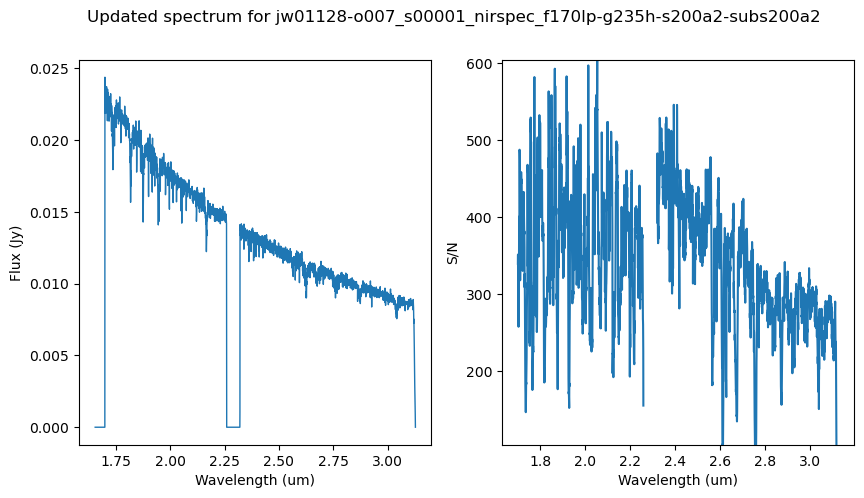

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(f'Updated spectrum for {spec3_name}')

# pipeline extracted spectrum
for i, name in enumerate(x1d_names):
    with fits.open(name) as hdulist:
        for extnum in range(len(hdulist)):
            hdu = hdulist[extnum]
            if hdu.name == 'EXTRACT1D':
                data = hdu.data
                header = hdu.header
                flux_plot = ax[0].plot(data['WAVELENGTH'], data['FLUX'], linewidth=1)
                error_range = ax[0].fill_between(data['WAVELENGTH'], 
                                                 data['FLUX'] - data['FLUX_ERROR'], 
                                                 data['FLUX'] + data['FLUX_ERROR'], alpha=0.2)
                s2n_data = data['FLUX'] / data['FLUX_ERROR']
                s2n = ax[1].plot(data['WAVELENGTH'], s2n_data)
                
                ax[0].set_xlabel(f"Wavelength ({header['TUNIT1']})")
                ax[0].set_ylabel(f"Flux ({header['TUNIT2']})")
                ax[1].set_xlabel(f"Wavelength ({header['TUNIT1']})")
                ax[1].set_ylabel(f"S/N")
                ax[1].set_ylim([np.percentile(s2n_data[np.isfinite(s2n_data)], 1),
                                np.percentile(s2n_data[np.isfinite(s2n_data)], 100)])

## Add an estimated flat error to the total error on the extracted flux
If the flat error has not been provided (i.e. the mean flat error is reported as zero or NaN, above), the calculated error may be underestimated for the spectrum.  If desired, an estimate of the systematic error due to flat correction can be added in place of the flat variance array.

For example, add a 1% overall error on the flux in place of the flat variance.

In [6]:
estimated_fractional_error = 0.01
for name in x1d_names:
    with fits.open(name, 'update') as hdulist:
        print(f'Updating error for {name} with additional estimated flat error')
        for extnum in range(len(hdulist)):
            hdu = hdulist[extnum]
            if hdu.name == 'EXTRACT1D':
                print(f"Extension {extnum}")

                # report value before correction
                print(f"\tMean error before update: {np.nanmean(hdu.data['FLUX_ERROR'])}\n")

                # report input values
                print(f"\tMean Poisson error: {np.sqrt(np.nanmean(hdu.data['FLUX_VAR_POISSON']))}")
                print(f"\tMean read noise error: {np.sqrt(np.nanmean(hdu.data['FLUX_VAR_RNOISE']))}")

                # estimate a flat error
                flat_var = (estimated_fractional_error * hdu.data['FLUX']) ** 2
                print(f"\tMean estimated flat error: {np.sqrt(np.nanmean(flat_var))}\n")
                
                # store it in the flat column
                hdu.data['FLUX_VAR_FLAT'] = flat_var
                
                # add components in quadrature, ignoring NaNs
                components = [hdu.data['FLUX_VAR_POISSON'], 
                              hdu.data['FLUX_VAR_RNOISE'], 
                              flat_var]
                new_error = np.sqrt(np.nansum(components, axis=0))
                
                # update FITS file
                hdu.data['FLUX_ERROR'] = new_error

                # report value after correction
                print(f"\tMean error after update: {np.nanmean(hdu.data['FLUX_ERROR'])}\n")

Updating error for jw01128-o007_s00001_nirspec_f170lp-g235h-s200a2-subs200a2_x1d.fits with additional estimated flat error
Extension 1
	Mean error before update: 4.367946929252044e-05

	Mean Poisson error: 2.708485479920139e-05
	Mean read noise error: 1.8706247553682953e-06
	Mean estimated flat error: 0.000140212684996825

	Mean error after update: 0.000134695846830445



Plot the 1D spectra with errors marked as a shaded range around the flux. Also plot the signal-to-noise ratio (S/N) for the spectrum.

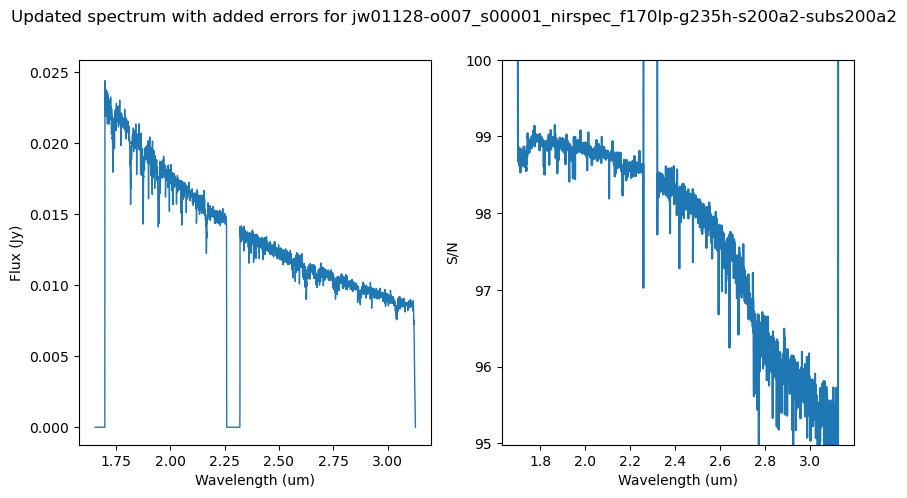

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(f'Updated spectrum with added errors for {spec3_name}')

# pipeline extracted spectrum
for i, name in enumerate(x1d_names):
    with fits.open(name) as hdulist:
        for extnum in range(len(hdulist)):
            hdu = hdulist[extnum]
            if hdu.name == 'EXTRACT1D':
                data = hdu.data
                header = hdu.header
                flux_plot = ax[0].plot(data['WAVELENGTH'], data['FLUX'], linewidth=1)
                error_range = ax[0].fill_between(data['WAVELENGTH'], 
                                                 data['FLUX'] - data['FLUX_ERROR'], 
                                                 data['FLUX'] + data['FLUX_ERROR'], alpha=0.2)
                s2n_data = data['FLUX'] / data['FLUX_ERROR']
                s2n = ax[1].plot(data['WAVELENGTH'], s2n_data)
                
                ax[0].set_xlabel(f"Wavelength ({header['TUNIT1']})")
                ax[0].set_ylabel(f"Flux ({header['TUNIT2']})")
                ax[1].set_xlabel(f"Wavelength ({header['TUNIT1']})")
                ax[1].set_ylabel(f"S/N")
                ax[1].set_ylim([np.percentile(s2n_data[np.isfinite(s2n_data)], 1),
                                np.percentile(s2n_data[np.isfinite(s2n_data)], 100)])

## Add an estimated flat error to the 2D spectral error images

The 2D spectral files contain similar component variance information, stored in image extensions rather table columns. The error on the flux, in the ERR extension, generally was not impacted by the all-NaN propagation issue in the pipeline, but it may still be underestimated for some reference flat files.  An additional error may be added to these products in a similar manner to the 1D correction.

Apply the same systematic 1% error to the s2d and cal data products.

In [8]:
for name in s2d_names + cal_names:
    with fits.open(name, 'update') as hdulist:
        print(f'Updating error for {name} with additional estimated flat error')
        spectral_set = 0
        flux, error_extnum, var_p, var_r = None, None, None, None
        for extnum in range(len(hdulist)):
            hdu = hdulist[extnum]
            if hdu.name == 'SCI':
                # SCI extension marks the start of a new spectral set
                spectral_set += 1
                
                # keep the flux from the SCI extension
                flux = hdu.data
            elif hdu.name == 'ERR':
                # keep the ERR extension number, to update later
                error_extnum = extnum
            elif hdu.name == 'VAR_POISSON':
                # keep the poisson variance
                var_p = hdu.data
            elif hdu.name == 'VAR_RNOISE':
                # keep the read noise variance
                var_r = hdu.data
            elif hdu.name == 'VAR_FLAT':
                # ignore the input flat variance, update the error extension for the set
                print(f"Spectral set {spectral_set}")
                
                # report value before correction
                print(f"\tMean error before update: {np.nanmean(hdulist[error_extnum].data)}\n")

                # report input values
                print(f"\tMean Poisson error: {np.sqrt(np.nanmean(var_p))}")
                print(f"\tMean read noise error: {np.sqrt(np.nanmean(var_r))}")

                # estimate a 1% flat error
                flat_var = (estimated_fractional_error * flux) ** 2
                print(f"\tMean estimated flat error: {np.sqrt(np.nanmean(flat_var))}\n")
                
                # store it in the VAR_FLAT image
                hdu.data = flat_var
                
                # add components in quadrature, ignoring NaNs
                components = [var_p, var_r, flat_var] 
                new_error = np.sqrt(np.nansum(components, axis=0))
                
                # update FITS file
                hdulist[error_extnum].data = new_error

                # report value after correction
                print(f"\tMean error after update: {np.nanmean(hdulist[error_extnum].data)}\n")

Updating error for jw01128-o007_s00001_nirspec_f170lp-g235h-s200a2-subs200a2_s2d.fits with additional estimated flat error
Spectral set 1
	Mean error before update: 8920.2021484375

	Mean Poisson error: 2.497206926345825
	Mean read noise error: 0.09679931402206421
	Mean estimated flat error: 1.4373164117231774e-11

	Mean error after update: 0.009372822940349579

Updating error for jw01128-o007_s00001_nirspec_f170lp-g235h-s200a2-subs200a2_cal.fits with additional estimated flat error
Spectral set 1
	Mean error before update: 24100.619140625

	Mean Poisson error: 0.002075228840112686
	Mean read noise error: 0.001596342772245407
	Mean estimated flat error: 2.4002516987864375e-11

	Mean error after update: 9.0021152573172e-05

Spectral set 2
	Mean error before update: 22522.4375

	Mean Poisson error: 3.9622538089752197
	Mean read noise error: 0.15252983570098877
	Mean estimated flat error: 0.07978412508964539

	Mean error after update: 0.00978818815201521

Spectral set 3
	Mean error before

A new spectrum can now be extracted from the updated files, if desired. The new spectrum should now have an appropriate error array.

In [9]:
new_x1d_names = []
for s2d in s2d_names:
    new_spectrum = Extract1dStep.call(s2d)
    x1d_name = s2d.replace('s2d', 'x1d_updated')
    new_spectrum.save(x1d_name)
    new_x1d_names.append(x1d_name)

2024-03-11 12:54:23,839 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2024-03-11 12:54:23,879 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('jw01128-o007_s00001_nirspec_f170lp-g235h-s200a2-subs200a2_s2d.fits',).
2024-03-11 12:54:23,880 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'ifu_set_srctype': None, 'ifu_rscale': None, 'soss_atoca': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_wave_grid_in': None, 'soss_wave_grid_out': None,

Plot the new spectrum and corresponding S/N.  Note that the S/N for the new extracted spectrum is not identical to the updated spectrum above, due to the error propagation in the extraction process.

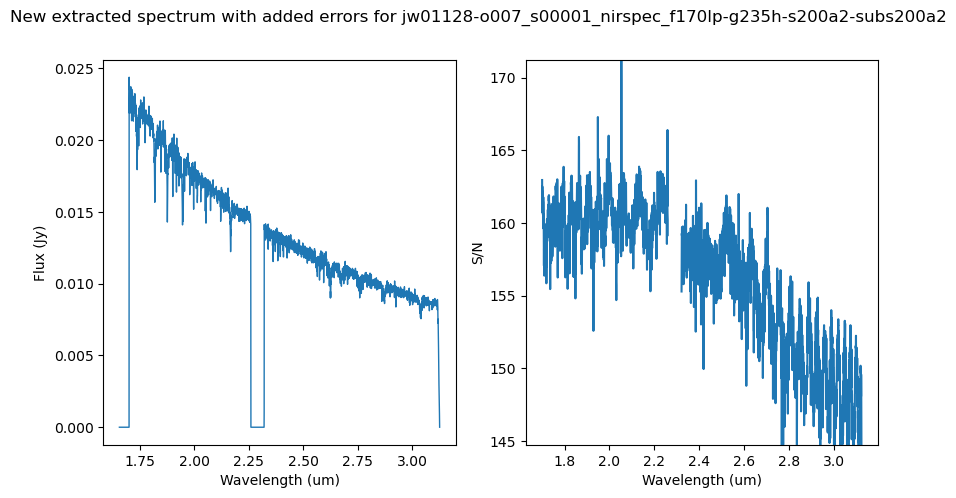

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(f'New extracted spectrum with added errors for {spec3_name}')

# pipeline extracted spectrum
for i, name in enumerate(new_x1d_names):
    with fits.open(name) as hdulist:
        for extnum in range(len(hdulist)):
            hdu = hdulist[extnum]
            if hdu.name == 'EXTRACT1D':
                data = hdu.data
                header = hdu.header
                flux_plot = ax[0].plot(data['WAVELENGTH'], data['FLUX'], linewidth=1)
                error_range = ax[0].fill_between(data['WAVELENGTH'], 
                                                 data['FLUX'] - data['FLUX_ERROR'], 
                                                 data['FLUX'] + data['FLUX_ERROR'], alpha=0.2)
                s2n_data = data['FLUX'] / data['FLUX_ERROR']
                s2n = ax[1].plot(data['WAVELENGTH'], s2n_data)
                
                ax[0].set_xlabel(f"Wavelength ({header['TUNIT1']})")
                ax[0].set_ylabel(f"Flux ({header['TUNIT2']})")
                ax[1].set_xlabel(f"Wavelength ({header['TUNIT1']})")
                ax[1].set_ylabel(f"S/N")
                ax[1].set_ylim([np.percentile(s2n_data[np.isfinite(s2n_data)], 1),
                                np.percentile(s2n_data[np.isfinite(s2n_data)], 100)])